# Investigating the Data Stream

[Previously](https://github.com/cwivagg/iiab_analytics/blob/main/notebooks/notebook20211222.md), we pulled some issue logs from the Internet-in-a-Box repository. Now, we'll take a quick look at the data. We'll start by loading the data itself and some basic dependencies.

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

DATA_HOME = "../.." # Just a local directory where we put the previous notebook entry's data.

menus = []
with open(os.path.join(DATA_HOME, "menus.json")) as f:
    for line in f:
        menu = json.loads(line)["menu_items_1"]
        menus.append(menu)

print("Example menu:\n\n" + str(menus[0]))

Example menu:

['en-oob', 'en-sample', 'en-test_zim', 'en-test_mod', 'en-map_admin', 'en-osm_viewer_v2', 'en-usb', 'en-kalite', 'en-raspberrypi_stackexchange_com_en_all', 'en-wikiquote_en_all_nopic', 'en-wiktionary_en_all_nopic', 'en-wikipedia_en_all_nopic', 'en-musictheory', 'en-olpc', 'en-asst_medical', 'en-math_expression', 'en-rpi_guide', 'en-peacebuilding', 'en-understanding_algebra', 'en-scratch', 'en-wikem', 'en-ebooks', 'en-practical_action', 'en-siyavula', 'en-algebra2go', 'en-boundless', 'en-credits']


## Issues Over Time

One simple question is how frequently issues are being created: will we want to rerun our data pipeline daily, weekly, or more rarely? Is the amount of data increasing? We approached these questions by using a simple command line  utility to parse the creation dates of the issues that we previously assembled:

```
# In DATA_HOME
cat iiab_issues.json|jq '.[]' -Sc|grep "sprunge"|jq '.created_at' -r
```

We leverage the knowledge that each issue containing data will have a URL to a Sprunge pastebin.

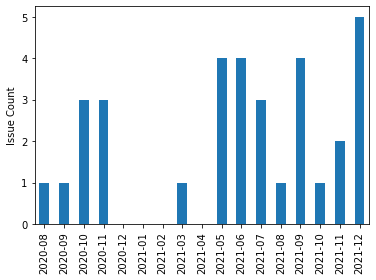

In [2]:
issue_dates = pd.read_csv(os.path.join(DATA_HOME, "creation_dates.txt"),
                          names=["issues"],
                          parse_dates=["issues"],
                          infer_datetime_format=True)
dates_df = issue_dates.groupby([issue_dates["issues"].dt.to_period('M')]).count().resample('M').sum().fillna(0)
ax = dates_df.plot.bar(legend=False)                # Cleaning up a bunch of messy display defaults.
ax.axes.get_xaxis().get_label().set_visible(False)  #
ax.set_ylabel("Issue Count")                        #
plt.show()

It looks like we don't have a lot of issues that submitted data files yet, but the number is increasing steadily over time, and a bit faster more recently.

# Dealing with Language

Our ultimate goal is to recommend groups of related modules to users who will be interested in them. In the short term, however, we just want to identify as many of these groups as we might be able to: we don't have a lot of data, so we won't be able to go very far. First, we'll investigate what languages we can plausibly make groups for. In the long term, we might hope to implicitly discover which languages go well together and match which users just from module- and user-level information, but since we have a small sample, we'll avoid making "We Look Stupid" mistakes by using a rule. We make use of the fact that each module's language is encoded with the two-letter [ISO 639-1 code](https://en.wikipedia.org/wiki/List_of_ISO_639-1_codes) and prepended to the module name:

In [3]:
from collections import Counter

def count_languages(menu):
    languages = [module[:2] for module in menu]
    return Counter(languages)

language_dicts = [count_languages(menu) for menu in menus]
for d in language_dicts:
    print(d)

Counter({'en': 27})
Counter({'en': 20})
Counter({'en': 13})
Counter({'en': 39})
Counter({'es': 25, 'en': 4})
Counter({'en': 39})
Counter({'en': 17})
Counter({'en': 20})
Counter({'en': 14})
Counter({'en': 15})
Counter({'en': 21})
Counter({'en': 11})
Counter({'es': 25, 'en': 4})
Counter({'fr': 21, 'en': 1})
Counter({'en': 14})
Counter({'en': 9})
Counter({'en': 133})
Counter({'en': 133})
Counter({'en': 16})
Counter({'es': 25, 'en': 4})
Counter({'en': 19})
Counter({'en': 10})


A quick scan of the module groups that we downloaded reveals that most of the users have chosen English modules, with a small handful choosing French and Spanish. These users have a few English modules each, but not a significant amount and the ones they do have are probably just defaults. Thus, for now, we'll just look at the menus that are majority-English.

In [4]:
def find_majority_language(menu):
    language_dict = count_languages(menu)
    return max(language_dict, key=language_dict.get)

english_menus = []
for menu in menus:
    if find_majority_language(menu) == "en":
        english_menus.append(menu)
print("Found {} English menus".format(len(english_menus)))

Found 18 English menus


In [5]:
from statistics import median

lengths = [len(menu) for menu in english_menus]
print("Average number of modules is {:.1f}".format(sum(lengths)/len(english_menus), '   '))
print("Median number of modules is {:.1f}".format(median(lengths)))

Average number of modules is 31.7
Median number of modules is 18.0


## Find Menu Similarities

Now that we have a basic idea of what the data looks like, we'll start looking for patterns in what modules people choose. We'll make use of a paradigm from the recommendations field, the item-item matrix. An item-item matrix counts the number of times two modules are chosen by the same user.

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

cts = CountVectorizer(analyzer=lambda x: x) # Usually, CountVectorizer is used to convert documents to bags of words.
                                            # Since our modules are already lists, we can skip this part.
X = cts.fit_transform(english_menus)
Xc = (X.T * X).toarray()
print(cts.get_feature_names_out()[:3])
print(Xc[:3,:3])

['en-PhET' 'en-afristory' 'en-algebra2go']
[[3 3 1]
 [3 4 1]
 [1 1 2]]


We can read this output like so: for the *i*th row and *j*th column, the matrix entry represents the number of times the *i*th and *j*th modules were selected together. So, en-PhET and en-algebra2go occurred in exactly one ```menu.json``` together, while en-PhET and en-afristory occurred in three ```menu.json``` lists together. The main diagonal is the number of times each module co-occurs with itself, or in other words, the total count of occurrences of that module. So en-PhET was selected three times, en-afristory four, and en-algebra2go two.